In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import math
from scipy import stats

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)

sns.set(style='darkgrid', palette='Set2')

In [3]:
YEARS = [1,2,3,4]

In [4]:
INPUT_PATH = 'data/input'
TRANSFORM_PATH = 'data/transformations'

In [5]:
df = pd.read_csv(f'{TRANSFORM_PATH}/pool.csv')

In [6]:
df = df[df['Курс'].isin(YEARS)]

In [7]:
df.head()

,Курс,Стать,Оцінка з математичої дисципліни,Оцінка з гуманітарної дисципліни,Оцінка з дисципліни за спеціальністю,"1.Коли починаю будь-яку роботу, як правило, сподіваюся на успіх",2.Під час діяльності виявляю активність,3.Маю схильність до виявлення ініціативи,"4.Під час виконання відповідальних завдань намагаюся, якщо це можливо, знайти причини відмовитися від них","5.Часто обираю крайнощі: або надто легкі, або занадто важкі завдання","6.Якщо зустрічаю перешкоди, як правило, не відступаю, а шукаю можливості їх подолання","7.Коли успіхи і невдачі трапляються впереміжку, більше звертаю увагу на успіхи, а невдачами нехтую","8.Коли успіхи і невдачі трапляються впереміжку, більше звертаю увагу на успіхи, а невдачами нехтую","9.Коли завдання складні, а часу мало, результат діяльності погіршується",10.Я зазвичай наполегливий у досягненні мети,11.Планую своє майбутнє на достатньо віддалену перспективу,"12.Якщо ризикую, то скоріше обдумано","13.Не дуже наполегливий у досягненні мети, особливо, якщо відсутній зовнішній контроль","14.Волію ставити перед собою середні або злегка завищені завдання, які реально можу виконати","15.Якщо під час виконання будь-якого завдання мене спіткає невдача, воно стає для мене менш привабливим","16.Коли успіхи і невдачі трапляються впереміжку, більше звертаю уваги на невдачі",17.Планую своє майбутнє лише на найближчий час,"18.Я досягаю кращих результатів, коли час виконання обмежений, навіть якщо завдання досить складне",19.Не відмовляюсь від поставленої мети навіть у разі невдачі під час виконання будь-якої роботи,"20Якщо завдання я обирав сам, тоді у разі невдачі воно ще більше мене приваблює","1.Вивчення цього предмета дає мені можливість дізнатися чимало важливого для себе, проявити свої здібності. #1","1.Вивчення цього предмета дає мені можливість дізнатися чимало важливого для себе, проявити свої здібності. #2","1.Вивчення цього предмета дає мені можливість дізнатися чимало важливого для себе, проявити свої здібності. #3","2.Предмет, що вивчається, мені цікавий, і я хочу знати якомога більше. #1","2.Предмет, що вивчається, мені цікавий, і я хочу знати якомога більше. #2","2.Предмет, що вивчається, мені цікавий, і я хочу знати якомога більше. #3","3.У вивчені цього предмета мені достатньо тих знань, які я отримую на заняттях. #1","3.У вивчені цього предмета мені достатньо тих знань, які я отримую на заняттях. #2","3.У вивчені цього предмета мені достатньо тих знань, які я отримую на заняттях. #3","4.Навчальні завдання з цього предмета мені нецікаві, я їх виконую, тому що цього вимагає викладач. #1","4.Навчальні завдання з цього предмета мені нецікаві, я їх виконую, тому що цього вимагає викладач. #2","4.Навчальні завдання з цього предмета мені нецікаві, я їх виконую, тому що цього вимагає викладач. #3","5.Труднощі, що виникають при вивченні предмета, роблять його для мене ще більш захопливим. #1","5.Труднощі, що виникають при вивченні предмета, роблять його для мене ще більш захопливим. #2","5.Труднощі, що виникають при вивченні предмета, роблять його для мене ще більш захопливим. #3",6.При вивченні предмета крім підручників і рекомендованої літератури я самостійно читаю додаткову літературу #1,6.При вивченні предмета крім підручників і рекомендованої літератури я самостійно читаю додаткову літературу #2,6.При вивченні предмета крім підручників і рекомендованої літератури я самостійно читаю додаткову літературу #3,"7.Вважаю, що важкі теоретичні питання з цього предмета можна було б не вивчати. #1","7.Вважаю, що важкі теоретичні питання з цього предмета можна було б не вивчати. #2","7.Вважаю, що важкі теоретичні питання з цього предмета можна було б не вивчати. #3","8.Якщо щось не виходить з цього предмета, прагну розібратися і дійти до суті. #1","8.Якщо щось не виходить з цього предмета, прагну розібратися і дійти до суті. #2","8.Якщо щось не виходить з цього предмета, прагну розібратися і дійти до суті. #3","9.На заняттях з цього предмета у мене часто буває такий стан, коли «зовсім не хочеться вчит

In [8]:
df_res = df[[
    'Курс',
    'Стать',
    'Оцінка з математичої дисципліни',
    'Оцінка з гуманітарної дисципліни',
    'Оцінка з дисципліни за спеціальністю']].copy()
# df_res = df[['Курс',
#  'Стать',
#  'Оцінка з організації та обробки електронної інформації',
#  'Оцінка з англійської',
#  'Оцінка з мов програмування']].copy()

# df_res.columns = [
#     'Курс',
#     'Стать',
#     'Оцінка з математичої дисципліни',
#     'Оцінка з гуманітарної дисципліни',
#     'Оцінка з дисципліни за спеціальністю']

# Data preprocessing

### Test 1

In [9]:
start_col = '1.Коли починаю будь-яку роботу, як правило, сподіваюся на успіх'
end_col = '20Якщо завдання я обирав сам, тоді у разі невдачі воно ще більше мене приваблює'
test_cols = df.columns[df.columns.get_loc(start_col):df.columns.get_loc(end_col)+1].tolist()

yes_cols = np.array([1, 2, 3, 6, 8, 10, 11, 12, 14, 16, 18]) - 1
no_cols = np.array([4, 5, 7, 9, 13, 15, 17])-1
point_intervals = {
    (1, 7):  'уникнення невдачі',
    (8, 13) : 'полюс не виражений',
    (14, 20): 'досягнення успіху (надія на успіх)',
}

In [10]:
for col in test_cols:
     df[col] = df[col].map({'так': 1, 'ні':0})

In [11]:
df_res['Тест №1'] = (df[test_cols].iloc[:, yes_cols]==1).sum(axis=1) \
    + (df[test_cols].iloc[:, no_cols]==0).sum(axis=1)

In [12]:
df_res['Тест №1 рівень'] = pd.cut(df_res['Тест №1'], bins=[-1, 7, 13, 20], labels =point_intervals.values() )

### Test 2

In [13]:
# rename columns for test 2
start_col = '1.Вивчення цього предмета дає мені можливість дізнатися чимало важливого для себе, проявити свої здібності. #1'
end_col = '20.Якби це було можливо, то я виключив цей предмет із розкладу(навчального плану). #3'


# start_col = np.argwhere(df.columns.get_loc(start_col))[0][0]
# end_col = np.argwhere(df.columns.get_loc(end_col))[-1][-1]
# cols = np.array(df.columns)
test_cols = df.columns[df.columns.get_loc(start_col):df.columns.get_loc(end_col)+1].tolist()
# cols[start_col:end_col+1] = [col + ' ' + n for col, n in zip(test_cols, ['#1', '#2', '#3'] * 20)]
# test_cols = cols[start_col:end_col+1].copy()
# df.columns = cols


test_math_cols = [col for col in test_cols if '#1' in col]
test_human_cols = [col for col in test_cols if '#2' in col]
test_prof_cols = [col for col in test_cols if '#3' in col]

yes_cols = np.array([1, 2, 5, 6, 8, 11, 12, 14, 17, 19]) - 1
no_cols = np.array([3, 4, 7, 9, 10, 13, 15, 16, 18, 20]) - 1

point_intervals = {
    (0, 5):  'низький рівень внутрішньої мотивації',
    (6, 14): 'середній рівень внутрішньої мотивації',
    (15, 20): 'високий рівень внутрішньої мотивації'
}

In [14]:
for col in test_cols:
     df[col] = df[col].map({
         '• Вірно':1, '• Напевно, вірно – (+)':1, 
         '• Напевно, невірно – (-);':0, '• Невірно – (- -).' : 0})

In [15]:
df_res['Тест №2.а'] = (df[test_math_cols].iloc[:, yes_cols]==1).sum(axis=1) \
    + (df[test_math_cols].iloc[:, no_cols]==0).sum(axis=1)

df_res['Тест №2.б'] = (df[test_human_cols].iloc[:, yes_cols]==1).sum(axis=1) \
    + (df[test_human_cols].iloc[:, no_cols]==0).sum(axis=1)

df_res['Тест №2.в'] = (df[test_prof_cols].iloc[:, yes_cols]==1).sum(axis=1) \
    + (df[test_prof_cols].iloc[:, no_cols]==0).sum(axis=1)

In [16]:
for col in ['Тест №2.а', 'Тест №2.б', 'Тест №2.в']:
    df_res[col+' '+'рівень'] = pd.cut(df_res[col], bins=[-1, 5, 14, 20], labels = point_intervals.values())

### Test 3

In [17]:
start_col = '1.Тому що мені подобається обрана професія'
end_col = '34.Бо хочу отримати диплом із гарними оцінками, щоб мати перевагу над іншими.'
test_cols = df.columns[df.columns.get_loc(start_col):df.columns.get_loc(end_col)+1].tolist()

scales = [
    [7, 10, 14, 32],
    [6, 12, 13, 15, 19],
    [8, 9, 29, 30, 34],
    [1, 2, 3, 4, 5, 26],
    [27, 28],
    [17, 18, 20, 21, 22, 23, 24],
    [11, 16, 25, 31, 33]
]

In [18]:
for i, scale in enumerate(scales):
    scale = np.array(scale) - 1
    df_res[f'Тест №3.{i+1}'] = df[test_cols].iloc[:, scale].mean(axis=1)

In [19]:
df_res.head()

,Курс,Стать,Оцінка з математичої дисципліни,Оцінка з гуманітарної дисципліни,Оцінка з дисципліни за спеціальністю,Тест №1,Тест №1 рівень,Тест №2.а,Тест №2.б,Тест №2.в,Тест №2.а рівень,Тест №2.б рівень,Тест №2.в рівень,Тест №3.1,Тест №3.2,Тест №3.3,Тест №3.4,Тест №3.5,Тест №3.6,Тест №3.7
0,1,ж,100,74,95,8,полюс не виражений,2,2,1,низький рівень внутрішньої мотивації,низький рівень внутрішньої мотивації,низький рівень внутрішньої мотивації,3.00,3.2,4.2,3.166667,3.0,3.428571,2.0
1,1,ч,86,80,88,7,уникнення невдачі,11,10,12,середній рівень внутрішньої мотивації,середній рівень внутрішньої мотивації,середній рівень внутрішньої мотивації,3.50,2.4,3.4,4.333333,4.0,4.000000,3.4
2,1,ж,82,94,89,9,полюс не виражений,15,8,8,високий рівень внутрішньої мотивації,середній рівень внутрішньої мотивації,середній рівень внутрішньої мотивації,3.75,3.2,3.8,4.833333,3.0,4.142857,3.4
3,1,ч,76,76,76,9,полюс не виражений,11,9,11,середній рівень внутрішньої мотивації,середній рівень внутрішньої мотивації,середній рівень внутрішньої мотивації,3.50,4.4,4.0,3.833333,4.5,3.714286,4.6
4,1,ж,71,71,71,6,уникнення невдачі,10,5,8,середній рівень внутрішньої мотивації,низький рівень внутрішньої мотивації,середній рівень внутрішньої мотивації,3.50,3.0,4.0,4.166667,3.5,4.000000,3.4


### Скласти інтервальний статистичний ряд (таблицю частот) для кожного тесту. Кількість інтервалів групування для тесту 1 — три, для тесту 2– чотири, для наступних тестів -формула Стерджесса.

In [20]:
bins=3
col = 'Тест №1'
print(pd.cut(df_res[col], bins=bins).value_counts().sort_index())

(2.987, 7.333]     17
(7.333, 11.667]    54
(11.667, 16.0]     30
Name: Тест №1, dtype: int64


In [21]:
bins=4
for col in [
    'Тест №2.а',
    'Тест №2.б',
    'Тест №2.в'
]:
    print(col)
    print(pd.cut(df_res[col], bins=bins).value_counts().sort_index())

Тест №2.а
(0.982, 5.5]     8
(5.5, 10.0]     52
(10.0, 14.5]    26
(14.5, 19.0]    15
Name: Тест №2.а, dtype: int64
Тест №2.б
(0.982, 5.5]     7
(5.5, 10.0]     50
(10.0, 14.5]    28
(14.5, 19.0]    16
Name: Тест №2.б, dtype: int64
Тест №2.в
(0.982, 5.5]     6
(5.5, 10.0]     58
(10.0, 14.5]    24
(14.5, 19.0]    13
Name: Тест №2.в, dtype: int64


In [22]:
bins = int(1+np.log2(df_res.shape[0]))
for col in [
    'Тест №3.1',
    'Тест №3.2',
    'Тест №3.3',
    'Тест №3.4',
    'Тест №3.5',
    'Тест №3.6',
    'Тест №3.7']:
    print(col)
    print(pd.cut(df_res[col], bins=bins).value_counts().sort_index())

Тест №3.1
(1.997, 2.429]     6
(2.429, 2.857]    13
(2.857, 3.286]    24
(3.286, 3.714]    21
(3.714, 4.143]    19
(4.143, 4.571]    11
(4.571, 5.0]       7
Name: Тест №3.1, dtype: int64
Тест №3.2
(1.196, 1.743]     8
(1.743, 2.286]    11
(2.286, 2.829]    15
(2.829, 3.371]    31
(3.371, 3.914]    19
(3.914, 4.457]    13
(4.457, 5.0]       4
Name: Тест №3.2, dtype: int64
Тест №3.3
(0.996, 1.571]     1
(1.571, 2.143]    16
(2.143, 2.714]    11
(2.714, 3.286]    26
(3.286, 3.857]    26
(3.857, 4.429]    14
(4.429, 5.0]       7
Name: Тест №3.3, dtype: int64
Тест №3.4
(0.996, 1.571]     1
(1.571, 2.143]     0
(2.143, 2.714]     3
(2.714, 3.286]     3
(3.286, 3.857]    36
(3.857, 4.429]    29
(4.429, 5.0]      29
Name: Тест №3.4, dtype: int64
Тест №3.5
(1.496, 2.0]     3
(2.0, 2.5]       7
(2.5, 3.0]      18
(3.0, 3.5]      26
(3.5, 4.0]      26
(4.0, 4.5]      11
(4.5, 5.0]      10
Name: Тест №3.5, dtype: int64
Тест №3.6
(1.711, 2.184]     2
(2.184, 2.653]     3
(2.653, 3.122]    17
(3.122

# Graphs

2. (Візуалізація — 2б) Візуалізувати дані (для статті, оцінок, ознак з тестів 1,2,3). Побудувати полігон, гістограму, емпіричну функцію розподілу, кумулятивну криву,  - “”відмітити на ній медіану та квартилі для оцінок, ознак з тестів 1, 2.

3. (числові х-ки центральної тенденції та розкиду для оцінок та 2-х тестів — 2 б) Обчислити числові характеристики центральної тенденції та розкиду: вибіркове середнє, дисперсію, середньок - вадратичне відхилення, моду, медіану, коефіцієнти асиметрії та ексцесу.  Для обчислення застосувати табл.1 з прикладу 1.

4. (коробки з вусами  для оцінок та 2-х тестів — 2б)   Побудувати коробки з вусами відносно середнього і відносно медіани.


## All years

In [23]:
# df_res['Курс'].value_counts().sort_index()

Text(0.5, 1.0, 'Розподіл студентів за статтю')

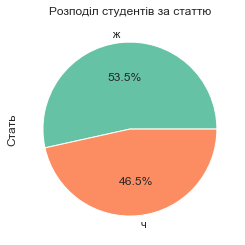

In [24]:
gender = df_res['Стать'].value_counts(normalize=True)
gender.plot(kind='pie', autopct='%1.1f%%');
plt.title('Розподіл студентів за статтю')

Text(0.5, 1.0, 'Кількість студентів, що пройшли опитування')

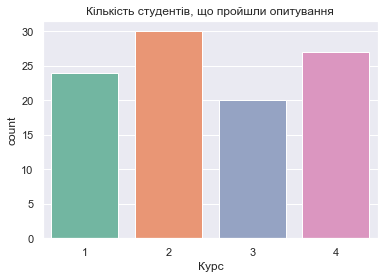

In [25]:
sns.countplot(data=df_res, x = 'Курс')
plt.title('Кількість студентів, що пройшли опитування')

In [26]:
def percentile(data, percentile):
    data = data.copy()
    data = data.dropna()
    size = len(data)
    return sorted(data)[int(math.ceil((size * percentile) / 100)) - 1]

def _skewness(X):
    means = X.mean()
    diffx,n = X-X.mean(), X.size
    skew = (1/n * np.sum(diffx**3))/((1/(n-1) * np.sum(diffx**2))**1.5)
    return skew

def _kurtosis(X):
    mu,var = X.mean(),np.var(X)       
    diffx,n = X-mu, X.size
    kurt = ((1/n * np.sum(diffx**4)) / (1/n * np.sum(diffx**2))**2) - 3        
    return kurt

def get_stats(df):
    df = df.copy()
    df = df.select_dtypes(np.number)
    df_descr = pd.DataFrame()
    df_descr['count'] = df.notna().sum()
    df_descr['mean'] = df.sum() / df_descr['count']
    df_descr['mode'] = df.apply(lambda x: x.value_counts().index[0])
    df_descr['std'] = np.sqrt(np.sum((df - df_descr['mean'])**2) / (df_descr['count']-1))
    df_descr['min'] = df.apply(lambda x: sorted(x.dropna())[0])
    df_descr['25%'] = df.apply(lambda x: percentile(x, 25))
    df_descr['50%'] = df.apply(lambda x: percentile(x, 50))
    df_descr['75%'] = df.apply(lambda x: percentile(x, 75))
    df_descr['max'] = df.apply(lambda x: sorted(x.dropna())[-1])
    df_descr['skewness'] = df.apply(lambda x: _skewness(x))
    df_descr['kurtosis'] = df.apply(lambda x: _kurtosis(x))
    
    return df_descr.T

,Оцінка з математичої дисципліни,Оцінка з гуманітарної дисципліни,Оцінка з дисципліни за спеціальністю
count,101.000000,101.000000,101.000000
mean,77.425743,84.564356,82.495050
mode,67.000000,82.000000,73.000000
std,10.708265,10.301860,9.165832
min,60.000000,63.000000,60.000000
25%,67.000000,77.000000,74.000000
50%,77.000000,83.000000,82.000000
75%,86.000000,94.000000,90.000000
max,100.000000,100.000000,100.000000
skewness,0.125303,-0.165736,-0.085881


Text(0.5, 1.0, 'Середні оцінки')

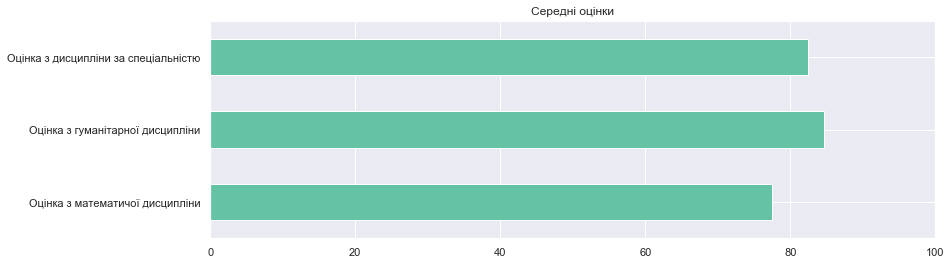

In [27]:
grade_cols = ['Оцінка з математичої дисципліни',
       'Оцінка з гуманітарної дисципліни',
       'Оцінка з дисципліни за спеціальністю']
df_res[grade_cols].mean().plot(kind='barh', figsize=(13, 4))
display(get_stats(df_res[grade_cols]))
plt.xlim(0, 100);
plt.title('Середні оцінки')

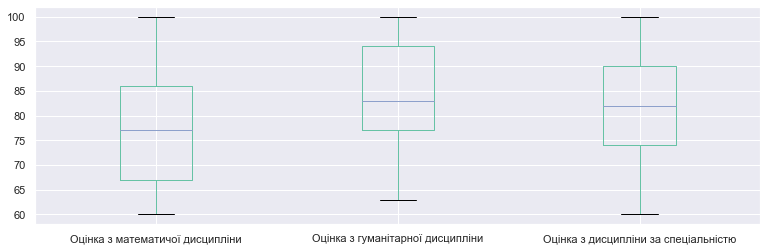

In [28]:
df_res[grade_cols].plot(kind='box', figsize=(13, 4))

In [29]:
# from scipy.stats import skew, kurtosis

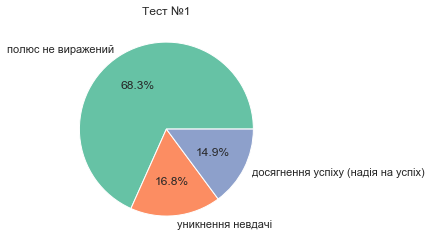

In [30]:
col = 'Тест №1'
df_res[col+' рівень'].value_counts().plot(kind='pie' , autopct='%1.1f%%')
plt.title(col)
plt.ylabel(None);

Тест 1: Приблизно 2/3 студентів не мають вираженого полюсу, студентів орієнтованих на уникнення невдач і надію на успіх приблизно однакова кількість.

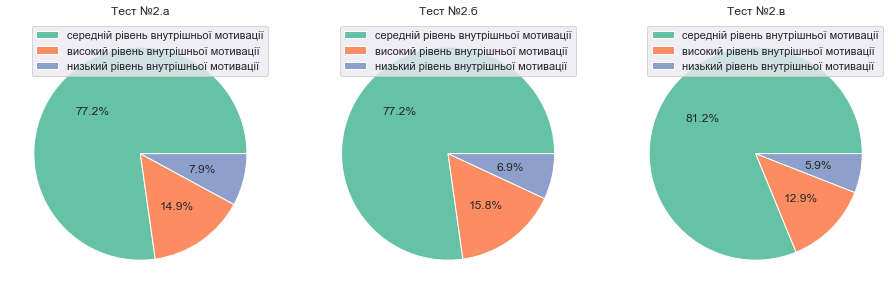

In [31]:
t_cols = ['Тест №2.а','Тест №2.б', 'Тест №2.в']

fig, ax = plt.subplots(1, 3, figsize=(13, 10))
for i, col in enumerate(t_cols):
    df_res[col+' рівень'].value_counts().plot(kind='pie' , autopct='%1.1f%%', labels=None,ax = ax[i])
    ax[i].set_title(col)
    ax[i].set_ylabel(None);
    ax[i].legend(labels=df_res[col+' рівень'].value_counts().index)
plt.tight_layout()

Тест 2: Приблизно 4/5 студентів мають середній рівень внутрішньої мотивації незалежно від предмету.

,Тест №1
count,101.000000
mean,10.019802
mode,8.000000
std,2.810623
min,3.000000
25%,8.000000
50%,10.000000
75%,12.000000
max,16.000000
skewness,0.009396


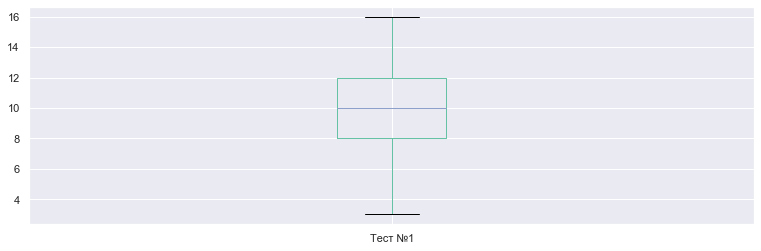

,Тест №2.а,Тест №2.б,Тест №2.в
count,101.000000,101.000000,101.000000
mean,10.574257,10.673267,10.356436
mode,10.000000,10.000000,10.000000
std,3.341696,3.490298,3.604398
min,1.000000,1.000000,1.000000
25%,10.000000,9.000000,8.000000
50%,10.000000,10.000000,10.000000
75%,12.000000,12.000000,12.000000
max,19.000000,19.000000,19.000000
skewness,-0.030495,-0.043168,0.291406


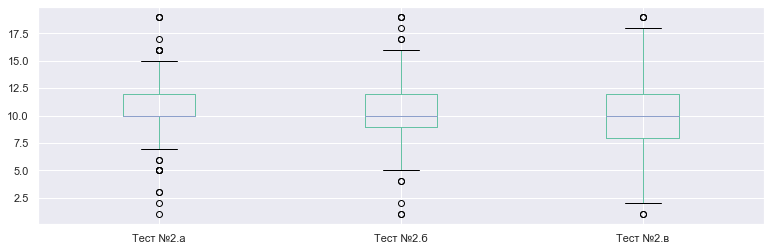

,Тест №3.1,Тест №3.2,Тест №3.3,Тест №3.4,Тест №3.5,Тест №3.6,Тест №3.7
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,3.490924,3.089109,3.184653,4.028053,3.673267,3.567185,3.457426
mode,3.500000,3.000000,3.800000,4.166667,3.500000,3.571429,3.200000
std,0.691004,0.850165,0.899548,0.668360,0.766276,0.646957,0.652587
min,2.000000,1.200000,1.000000,1.000000,1.500000,1.714286,2.000000
25%,3.000000,2.600000,2.600000,3.666667,3.000000,3.142857,3.000000
50%,3.500000,3.000000,3.200000,4.166667,3.500000,3.571429,3.400000
75%,4.000000,3.600000,3.800000,4.500000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
skewness,0.202201,-0.116420,-0.029864,-1.206364,-0.256844,0.059457,0.288288


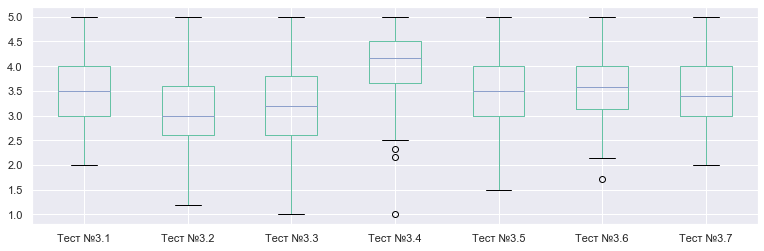

In [32]:
test_cols = [
    ['Тест №1'],
    ['Тест №2.а','Тест №2.б', 'Тест №2.в'],
    ['Тест №3.1', 'Тест №3.2', 'Тест №3.3',
       'Тест №3.4', 'Тест №3.5', 'Тест №3.6', 'Тест №3.7']
]

for t_cols in (test_cols):
#     df_res[t_cols].mean().plot(kind='bar', figsize=(13, 4), label = 'Середнє значення відповідей')
    df_res[t_cols].plot(kind='box', figsize=(13, 4))
    display(get_stats(df_res[t_cols]))
    
    
#     plt.legend(loc='lower center')
    plt.show()
    plt.close()

Тест 3: Найважливішими для студентів є професійні мотиви.

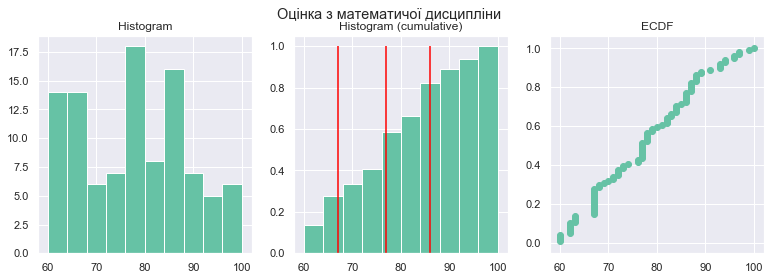

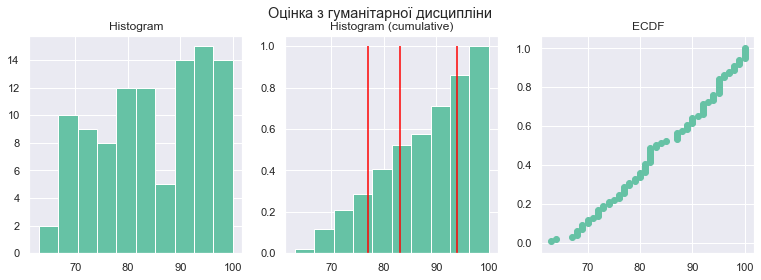

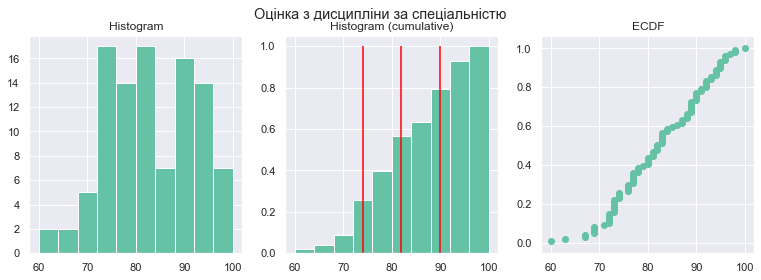

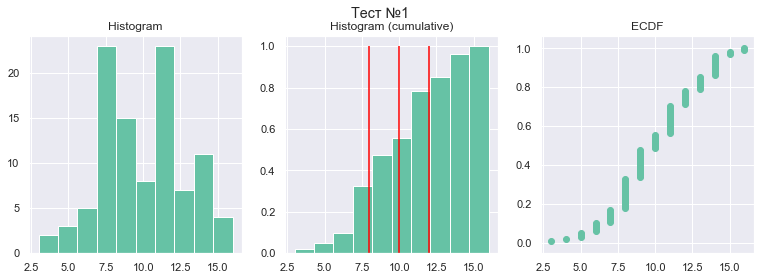

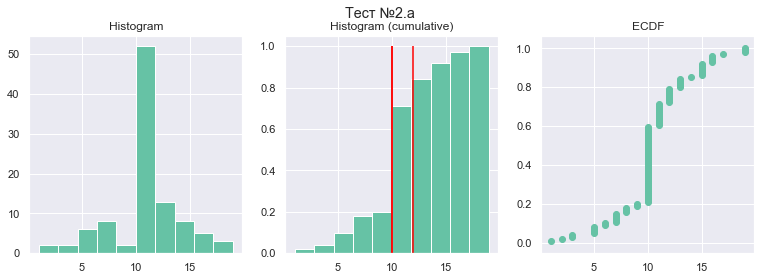

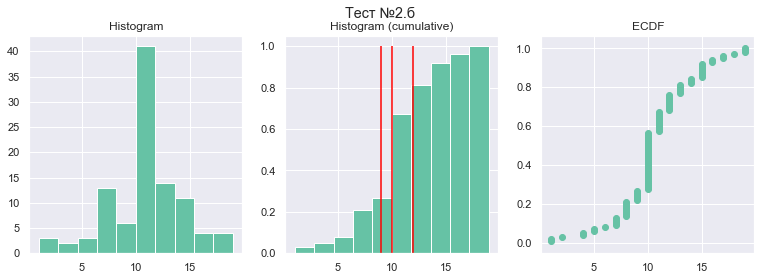

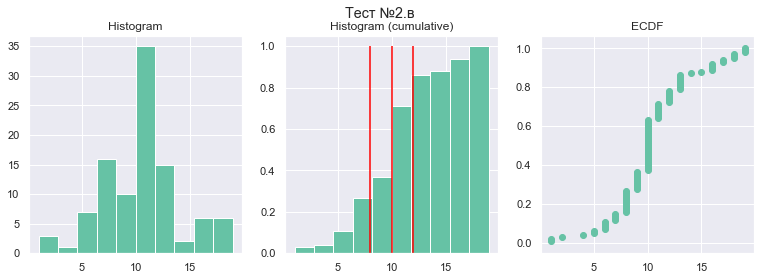

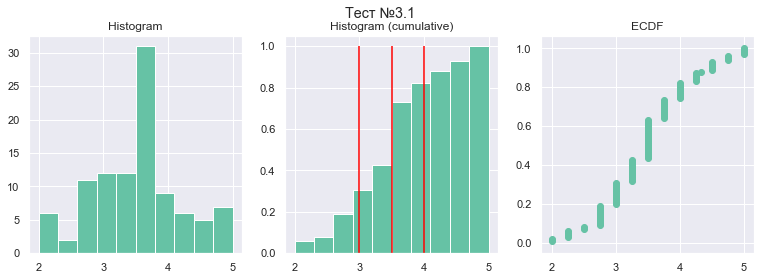

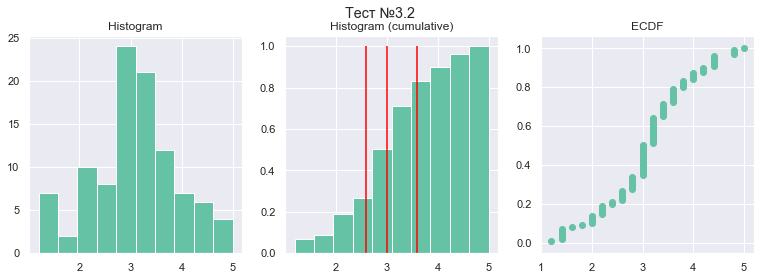

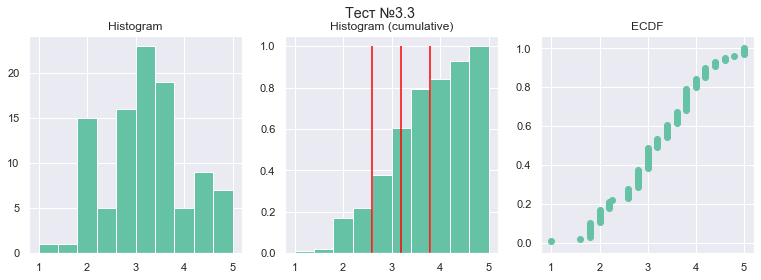

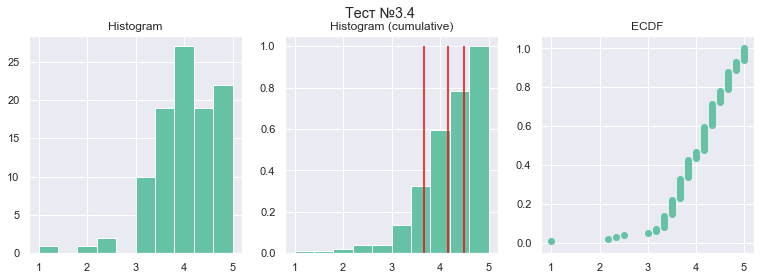

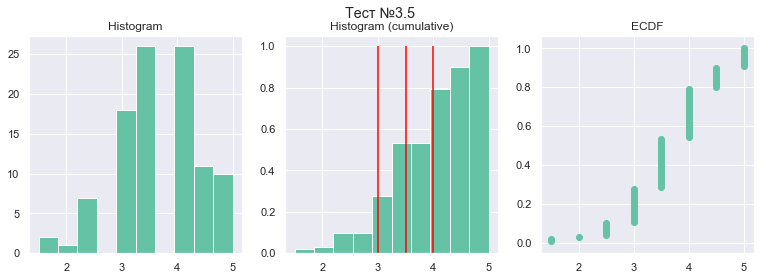

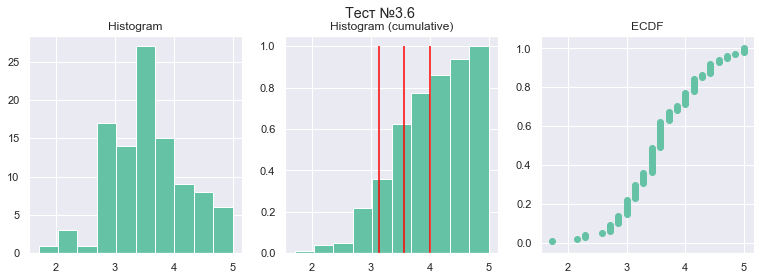

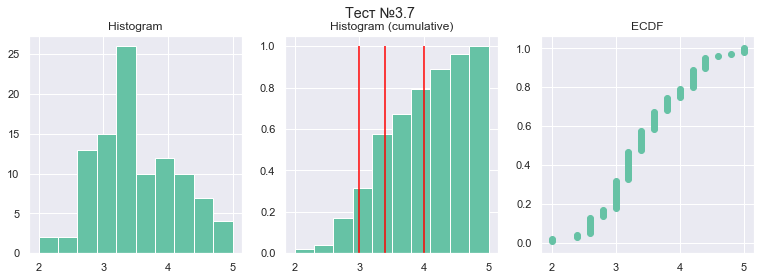

In [33]:
bins = 4

for col in df_res.select_dtypes(np.number).columns:
    if col in ['Курс', 'Стать']:
        continue
    fig, ax = plt.subplots(1,3, figsize=(13, 4))
    df_res[col].hist(ax = ax[0])
    ax[0].set_title('Histogram')
    
    df_res[col].hist(ax = ax[1], cumulative=True, density=True)
    ax[1].set_title('Histogram (cumulative)')
    
    n =df_res[col].shape[0]
    ax[2].scatter(np.sort(df_res[col]), np.arange(1, n+1) / n)
    ax[2].set_title('ECDF')
    
    
    percentiles = np.percentile(df_res[col], [25, 50, 75])
    ax[1].vlines(percentiles, ymin=0, ymax=1, color='r')
    
    plt.suptitle(col)
    plt.show()
    plt.close()

## By years

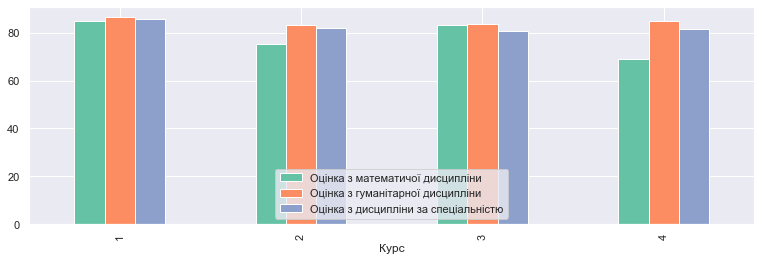

In [34]:
# df_res = df_res.loc[:,~df_res.columns.duplicated()]
grade_cols = ['Оцінка з математичої дисципліни',
       'Оцінка з гуманітарної дисципліни',
       'Оцінка з дисципліни за спеціальністю']
df_res.groupby(['Курс'])[grade_cols].mean().plot(kind='bar', figsize=(13, 4))
plt.legend(loc='lower center')

Оцінки: Інформатики мають високі оцінки з гуманітарних предметів. Також, студенти четвертого курсу мають порівняно низькі оцінки з математики.

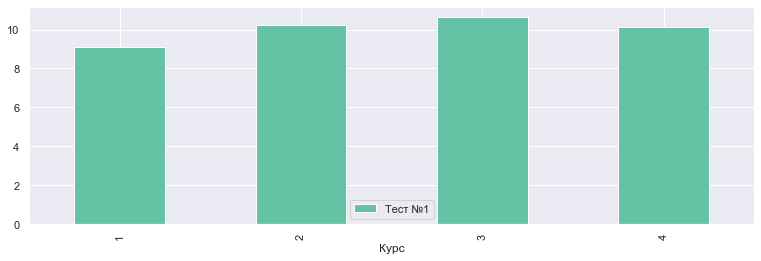

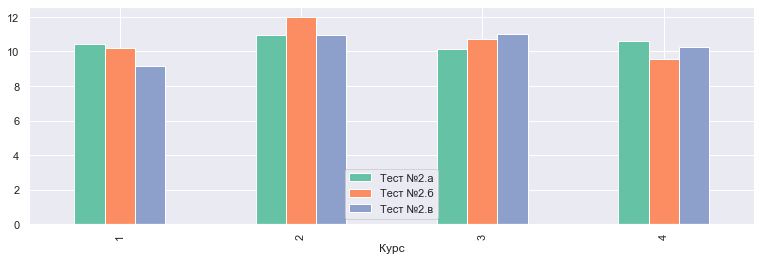

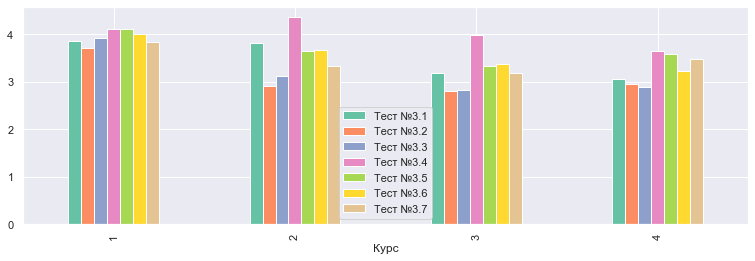

In [35]:
test_cols = [
    ['Тест №1'],
    ['Тест №2.а','Тест №2.б', 'Тест №2.в'],
    ['Тест №3.1', 'Тест №3.2', 'Тест №3.3',
       'Тест №3.4', 'Тест №3.5', 'Тест №3.6', 'Тест №3.7']
]
for t_cols in (test_cols):
    df_res.groupby(['Курс'])[t_cols].mean().plot(kind='bar', figsize=(13, 4))
    plt.legend(loc='lower center')
    plt.show()
    plt.close()

### 5. (статистичні похибки для оцінок та 2-х тестів -2б) Визначити статистичну похибку у тесті дослідження середнього балу з кожної дисципліни і у тесті дослідження проценту жіночої статті  (пропорції). Дослідити звязок з обємом вибірки. Визначити інтервальні оцінки.

In [42]:
# def sample_size_avg_score(x,delta=5.,t=1.96):
#     s = x.std()
#     return np.square(t*s/delta)

# def margin_of_error_avg_score(x,delta=5.,t=1.96):
#     n=sample_size_avg_score(x, delta)
#     s = x.std()
#     return t*s/np.sqrt(n)

# df_margin_of_error_est = pd.DataFrame()
# df_margin_of_error_est['sample_size'] = df_res[
#     grade_cols+['Тест №1', 'Тест №2.а']].apply(lambda x: sample_size_avg_score(x, 5))


# df_margin_of_error_est['margin_of_error'] = df_res[
#     grade_cols+['Тест №1', 'Тест №2.а']].apply(lambda x: margin_of_error_avg_score(x))
# df_margin_of_error_est

In [43]:
# def sample_size_proportion(x, delta,t=1.96):
#     p = x.value_counts(normalize=True).values[0]
#     return np.square((t*np.sqrt(p*(1-p)))/delta)

# def margin_of_error_proportion(x, n, t=1.96):
#     n=len(x)
#     p = x.value_counts(normalize=True).values[0]
#     return t * np.sqrt(p*(1-p)/n)

# for delta in [0.05, 0.2]:
#     sample_size_gender = sample_size_proportion(df_res['Стать'], delta)
#     margin_of_error_gender = margin_of_error_proportion(df_res['Стать'], sample_size_gender)
#     print(f'Стать (delta={delta})')
#     print('sample_size:',sample_size_gender )
#     print('margin_of_error:',margin_of_error_gender )
#     print()

### 6. (метод моментів для оцінок -2б) Методом моментів знайти параметри розподілів. (нормальний, Стьюдента), зробити графік, порівняти гістограму і графік розподілу.

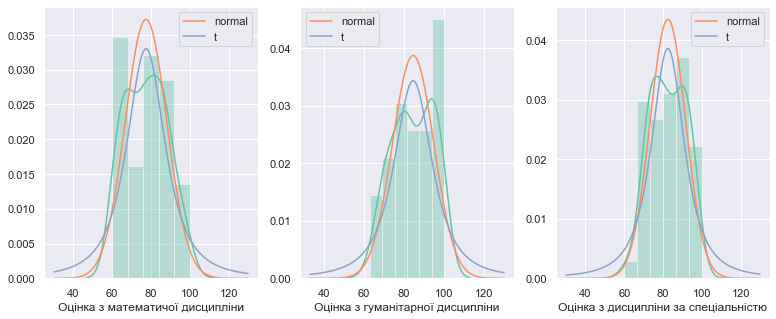

In [39]:
fix, axs= plt.subplots(1,3, figsize=(13,5))
for i,col in enumerate(grade_cols):
    
    mu,sigma = df_res[col].mean(),df_res[col].std()
    var = sigma**2
    dof = 2*var/(var-1)
    #data[col].hist(ax=axs[i//3,i%3],density=True)
    sns.distplot(df_res[col],ax=axs[i])
    lnspc = np.linspace(df_res[col].min()-30, df_res[col].max()+30, df_res[col].shape[0])
    
    pdf_n = stats.norm.pdf(lnspc,mu,sigma)
    pdf_t = stats.t.pdf(lnspc,dof,mu,sigma)
    axs[i].plot(lnspc, pdf_n, label="normal")
    axs[i].plot(lnspc, pdf_t, label="t")
    axs[i].legend()
    
#     sns.distplot(df_res[col],fit=stats.norm,kde=False,ax=axs[i])
    
fig.tight_layout(h_pad=5, w_pad=5)
fig.subplots_adjust(top=0.9)

З рисунків видно, що розподіли оцінок не є нормальними.

In [40]:
df_res.to_excel(f'{TRANSFORM_PATH}/tests results.xlsx', index=False)

In [41]:
df_res.shape

(101, 20)

# Висновки
- Оцінки. Інформатики мають високі оцінки з гуманітарних предметів. Також, студенти четвертого курсу мають порівняно низькі оцінки з математики.
- Тест 1. Приблизно 2/3 студентів не мають вираженого полюсу, студентів орієнтованих на уникнення невдач і надію на успіх приблизно однакова кількість.
- Тест 2. Приблизно 4/5 студентів мають середній рівень внутрішньої мотивації незалежно від предмету.
- Тест 3. Найважливішими для студентів є професійні мотиви.